# Part 3. Time Series Classification

In [21]:
from auxil.eeSar_seq import run
run()

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [1]:
%matplotlib inline
import ee
ee.Initialize()

### Train a neural network with the change signatures

In [2]:
# create a labeled change map using AAFC/ACI for 2017 growing season near Regina
bmap = ee.Image('users/mortcanty/zfl2020/reginasmall2017') \
           .select(ee.List.sequence(3,17))
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
    .first() \
    .clip(bmap.geometry())
labeled_bmap = ee.Image.cat(bmap,crop2017)

print( labeled_bmap.bandNames().getInfo() )

['T20170423_2', 'T20170505_3', 'T20170517_4', 'T20170529_5', 'T20170610_6', 'T20170622_7', 'T20170716_8', 'T20170728_9', 'T20170809_10', 'T20170821_11', 'T20170902_12', 'T20170914_13', 'T20170926_14', 'T20171008_15', 'T20171020_16', 'landcover']


In [3]:
# export to GEE for inspection
assetId = 'users/mortcanty/zfl2020/labeled_bmap'
assexport = ee.batch.Export.image.toAsset(labeled_bmap,
                  description='assetExportTask', 
                  assetId=assetId,scale=10,maxPixels=1e9)
print('Exporting labeled bmap to %s\n task id: %s'%(assetId,str(assexport.id)))
assexport.start()

Exporting labeled bmap to users/mortcanty/zfl2020/labeled_bmap
 task id: LPY6A7FUQVTAS5MQF5UYZ6PT


In [4]:
# export to drive for downloading
driveId = 'labeled_bmap'
drexport = ee.batch.Export.image.toDrive(labeled_bmap,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix=driveId,scale=10,maxPixels=1e9)
print('Exporting labeled bmap to %s\n task id: %s'%(driveId,str(drexport.id)))
drexport.start()

Exporting labeled bmap to labeled_bmap
 task id: 5ZN4T2RKEE7CBNAAWW47VBA7


In [5]:
!ls imagery/

class.tif    labeled_bmap.tif  radarsat2bonn
compare.png  labels.tif        southyorkshire


In [2]:
poly = ee.Image('users/mortcanty/zfl2020/labeled_bmap').geometry()

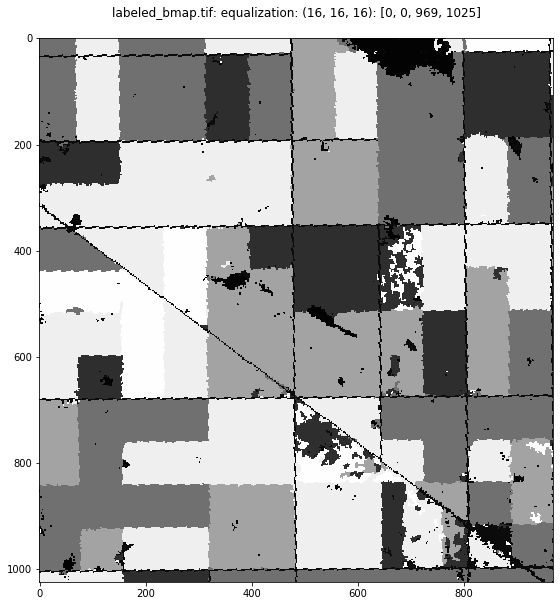

In [6]:
%run scripts/dispms -f imagery/labeled_bmap.tif -p [16,16,16] -e 4

In [30]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte
import numpy as np

gdal.AllRegister()                   
inDataset = gdal.Open('imagery/labeled_bmap.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_bmap = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_bmap[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()
driver = inDataset.GetDriver()     
inDataset = None
m = labeled_bmap.shape[0]
print(m)

993225


In [31]:
classnums = list(set(labeled_bmap[:,15]))
classnums.sort()
print(classnums)

[0.0, 20.0, 30.0, 34.0, 80.0, 110.0, 122.0, 133.0, 146.0, 153.0, 154.0, 158.0, 174.0, 196.0, 220.0]


In [32]:
i=0
labels = labeled_bmap[:,15]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8)    
print(labels[1000:1050])
print(set(labels))

[ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 12 12 12 12 12 12 12 12 12
 12 12]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [11]:
classnames = "['nc','water','barren','urban','wetland','grassland','pasture','barley','spring wheat','rapeseed','flax','soybeans','lentils','canaryseed','broadleaf']"

In [12]:
outDataset = driver.Create('imagery/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None

In [13]:
# random subset for training
n = 100000
idx = np.random.permutation(m)[0:n]
# training vectors normalized -1 to 1 
Xs = labeled_bmap[idx,0:15]
Xs = Xs/3.0
# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
print(Ls[0:5])
ls = np.zeros((n,15))
for i in range(n):
    ls[i,Ls[i]]=1.0
print(ls[0:5,:])

[12  9 13  9 12]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [14]:
import auxil.dnn as dnn
import time

start = time.time()
classifier = dnn.Dnn(Xs,ls,[20,20,20],epochs=20)
classifier.train()
print('time: %s'%str(time.time()-start))

time: 71.22263431549072


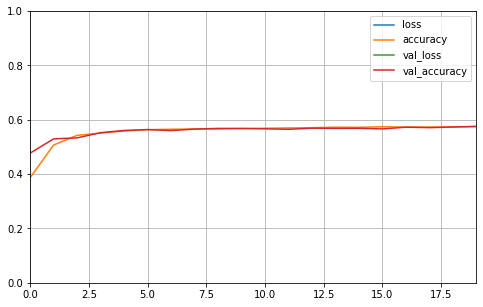

In [15]:
classifier.history()

In [16]:
classifier.test(Xs,ls)

0.42331

In [17]:
cls,Ms = classifier.classify(labeled_bmap[:,0:15]/3.0)                       

In [18]:
outDataset = driver.Create('imagery/class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None

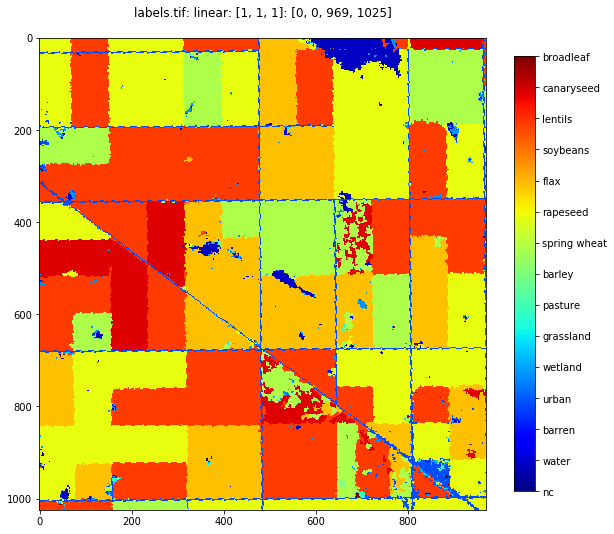

<Figure size 432x288 with 0 Axes>

In [19]:
%run scripts/dispms -f imagery/labels.tif -c -r "['nc','water','barren','urban','wetland','grassland','pasture','barley','spring wheat','rapeseed','flax','soybeans','lentils','canaryseed','broadleaf']"

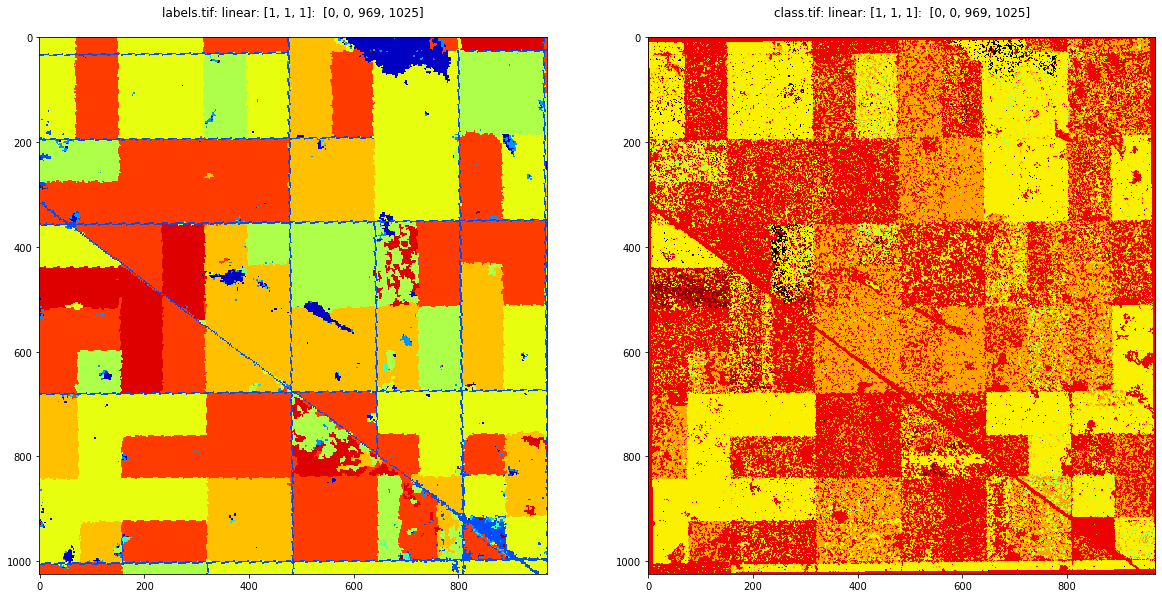

In [20]:
%run scripts/dispms -f imagery/labels.tif -c -F imagery/class.tif -C 